# Tässä Notebookissa on Fazer leipomoiden ennustus algoritmi. Sen saa toteutettua ajamalla jokaisen solun jäkrjestyksessä.

### Mikäli uutta dataa on saatavilla koulutukseen GPU:n saatavuus on vättämätön, jotta Random forest ei kestä päiviä...

### Jos uutta mallia ei tarvita, niin CPU riittää ennusteiden tekemiseen.

#### (Fazerin ennustetut arvot korvataan oikeilla PowerQueryssä, eikä tässä notebookissa, koska ACCOUNT tieto on vaikeasti saatavilla) 🥇

# Tunnistautuminen googleen

In [ ]:
# Tunnistautuminen ja yhdistäminen driveen

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Authenticated
Mounted at /content/drive


**Tulevien df merkitys:**


*   `vhs_data` = Pelkkä bq vhs data

*   `vhs_data2` = Koulutusdata jossa vhs dataan on joinattu POS datan `sales_amount`

*   `new_df` =  Ennustus df, eli tässä on haluttu timestamp ja tähän ennustetaan

*   `vhs_data3` = Pelkkä vhs data, johon tulee laittaa samat timestampit, kun `new_df`, koska notebookin lopussa verrataan kuinka tarkka ennuste oli vs toteutunut.

In [ ]:
# Tarkistetaan onko gpu käytössä

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("CUDA is available")
    print("Number of GPUs:", len(gpus))
    print("GPU details:", gpus)
else:
    print("No CUDA device found")


CUDA is available
Number of GPUs: 1
GPU details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Datan haku

## VHS datan hakeminen

In [ ]:
%%bigquery df --project touhua-001


WITH FirstAppearance AS (
  SELECT
    ean,
    MIN(timestamp) AS first_timestamp
  FROM
    `dm_sryhma.f_category_data`
  GROUP BY
    ean
),

sales_data AS (
  SELECT
    FORMAT_DATE('%Y-%m', DATE(
      CAST(year AS INT64),
      CAST(LPAD(CAST(month AS STRING), 2, '0') AS INT64),
      1
    )) AS date,
    CDT_level4_id,
    SUM(amount) AS amount
  FROM
    `touhua-001.fazer.stg_sryhma_sales_CDT_last`
  GROUP BY
    date, CDT_level4_id
),

sales_data_with_proportion AS (
  SELECT
    date,
    CDT_level4_id,
    amount,
    amount / SUM(amount) OVER (PARTITION BY date) AS sales_proportion
  FROM
    sales_data
),

supplier_sales AS (
  SELECT
    FORMAT_TIMESTAMP('%Y-%m', data.timestamp) AS date,
    d_product.supplierName,
    SUM(data.unitPrice) AS supplier_total_sales
  FROM
    `dm_sryhma.f_category_data` data
  LEFT JOIN
    `dm_sryhma.d_product` d_product ON d_product.ean = data.ean
  GROUP BY
    date, d_product.supplierName
),

total_sales AS (
  SELECT
    date,
    SUM(supplier_total_sales) AS total_sales
  FROM
    supplier_sales
  GROUP BY
    date
)

SELECT
  FORMAT_TIMESTAMP('%Y-%m', MAX(data.timestamp)) AS timestamp,
  location.chain AS Ketju,
  data.ean,
  d_product.supplierName,
  d_product.cdt_level4_id,
  ROUND(AVG(data.unitPrice), 2) AS unitPrice,
  COUNT(DISTINCT data.storeId) AS `Store count`,
  CASE
    WHEN FORMAT_TIMESTAMP('%Y-%m', MAX(data.timestamp)) = FORMAT_TIMESTAMP('%Y-%m', MIN(fa.first_timestamp)) THEN 1
    ELSE 0
  END AS isNew,
  ROUND(sd.amount, 4) AS cdt_amount,
  ROUND(sd.sales_proportion, 5) AS cdt_sales_proportion,
  ROUND(ss.supplier_total_sales / ts.total_sales, 5) AS supplier_sales_proportion
FROM
  `dm_sryhma.f_category_data` data
LEFT JOIN
  `dm_sryhma.d_product` d_product ON d_product.ean = data.ean
LEFT JOIN
  `touhua-001.dm_sryhma.d_location` location ON data.storeId = location.location_id
LEFT JOIN
  FirstAppearance fa ON data.ean = fa.ean
LEFT JOIN
  sales_data_with_proportion sd ON FORMAT_TIMESTAMP('%Y-%m', data.timestamp) = sd.date AND d_product.cdt_level4_id = sd.CDT_level4_id
LEFT JOIN
  supplier_sales ss ON FORMAT_TIMESTAMP('%Y-%m', data.timestamp) = ss.date AND d_product.supplierName = ss.supplierName
LEFT JOIN
  total_sales ts ON FORMAT_TIMESTAMP('%Y-%m', data.timestamp) = ts.date
WHERE
  EXISTS (
    SELECT
      data.storeId
    FROM
      `dm_sryhma.f_stores_sample_include` s
    WHERE
      data.storeId = s.storeId
      AND DATE(data.timestamp) >= DATE(s.startDate)
      AND (DATE(data.timestamp) <= DATE(s.endDate) OR s.endDate IS NULL)
  )
  AND FORMAT_TIMESTAMP('%Y-%m', data.timestamp) IN (
      '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07') # muuta halutut kuukaudet
  AND dm_account.GetCategoryPath(d_product.categoryName, d_product.subCategoryName, d_product.segmentName)
  IN (
    'Leivät, keksit ja leivonnaiset/Gluteenittomat/Gluteenittomat kotipaistotuotteet',
    'Leivät, keksit ja leivonnaiset/Gluteenittomat/Gluteenittomat makeat leivonnaiset',
    'Leivät, keksit ja leivonnaiset/Gluteenittomat/Gluteenittomat tummat leivät',
    'Leivät, keksit ja leivonnaiset/Gluteenittomat/Gluteenittomat vaaleat leivät',
    'Leivät, keksit ja leivonnaiset/Gluteenittomat/Muut leivät',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Donitsit',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Halvat',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Kakku- ja torttupohjat',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Kuivakakut',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Kääretortut',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Leivokset',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Makeat piirakat',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Muffinsit',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Munkit',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Muut konditoriatuotteet',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Muut makeat leivonnaiset',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Piirakat',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Pitkot ja täytepitkot',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Pullat',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Sesonkituotteet',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Tuoreet rinkelit',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Täytekakut',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Välipalatuotteet',
    'Leivät, keksit ja leivonnaiset/Leivonnaiset/Wienerit',
    'Leivät, keksit ja leivonnaiset/Leivät/Erikoisleivät',
    'Leivät, keksit ja leivonnaiset/Leivät/Kotona paistettavat',
    'Leivät, keksit ja leivonnaiset/Leivät/Muut vaaleat leivät',
    'Leivät, keksit ja leivonnaiset/Leivät/Paahtoleivät',
    'Leivät, keksit ja leivonnaiset/Leivät/Patongit',
    'Leivät, keksit ja leivonnaiset/Leivät/Rieskat',
    'Leivät, keksit ja leivonnaiset/Leivät/Sekaleivät',
    'Leivät, keksit ja leivonnaiset/Leivät/Sämpylät',
    'Leivät, keksit ja leivonnaiset/Leivät/Tummat leivät',
    'Leivät, keksit ja leivonnaiset/Leivät/Vaaleat leivät',
    'Leivät, keksit ja leivonnaiset/Paistopisteen tuotteet/Konditoriatuotteet',
    'Leivät, keksit ja leivonnaiset/Paistopisteen tuotteet/Makeat leivonnaiset',
    'Leivät, keksit ja leivonnaiset/Paistopisteen tuotteet/Tummat leivät',
    'Leivät, keksit ja leivonnaiset/Paistopisteen tuotteet/Tuoreet palaleivät',
    'Leivät, keksit ja leivonnaiset/Paistopisteen tuotteet/Tuoreet sämpylät',
    'Leivät, keksit ja leivonnaiset/Paistopisteen tuotteet/Vaaleat leivät',
    'Leivät, keksit ja leivonnaiset/Paistopisteen tuotteet/Välipalatuotteet',
    'Valmisruoka/Valmisateriat ja -keitot/Leivät, paninit ja wrapit',
    'Valmisruoka/Valmisateriat ja -keitot/Piirakat ja pasteijat'
)

GROUP BY
  FORMAT_TIMESTAMP('%Y-%m', data.timestamp), location.chain, data.ean, d_product.supplierName, d_product.cdt_level4_id,
  sd.amount, sd.sales_proportion, ss.supplier_total_sales, ts.total_sales
ORDER BY
  data.ean, location.chain, MAX(data.timestamp)

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,timestamp,Ketju,ean,supplierName,cdt_level4_id,unitPrice,Store count,isNew,cdt_amount,cdt_sales_proportion,supplier_sales_proportion
0,2023-09,alepa,41015438,KUCHENMEISTER GMBH,CAAAWAGAG,7.38,2,1,NaN,NaN,0.00004
1,2023-10,alepa,41015438,KUCHENMEISTER GMBH,CAAAWAGAG,7.38,2,0,NaN,NaN,0.00003
2,2023-11,alepa,41015438,KUCHENMEISTER GMBH,CAAAWAGAG,7.38,2,0,226551.60,0.00296,0.00003
3,2023-12,alepa,41015438,KUCHENMEISTER GMBH,CAAAWAGAG,7.38,3,0,260415.31,0.00337,0.00003
4,2024-01,alepa,41015438,KUCHENMEISTER GMBH,CAAAWAGAG,7.38,3,0,NaN,NaN,0.00004
...,...,...,...,...,...,...,...,...,...,...,...
146251,2023-12,sale,9998888931701,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWAMAK,12.61,1,0,4104606.29,0.05307,0.00000
146252,2024-01,sale,9998888931701,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWAMAK,12.61,1,0,4314104.78,0.05637,0.00000
146253,2024-02,sale,9998888931701,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWAMAK,12.61,1,0,4444757.04,0.06004,0.00000
146254,2024-03,sale,9998888931701,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWAMAK,12.61,1,0,4490353.06,0.05851,0.00000


### korjataan vähän dataframea

In [ ]:
vhs_data = df

import pandas as pd

# Muutetaan kaikki paitsi prisma tai s-market -> pienmyymälä
vhs_data.loc[~vhs_data['Ketju'].str.lower().isin(['prisma', 's-market', 'herkku']), 'Ketju'] = 'PIENMYYMÄLÄ'

# kaikki kirjaimet isoiksi
vhs_data['Ketju'] = vhs_data['Ketju'].str.upper()

print(vhs_data['Ketju'].unique())

vhs_data['timestamp'] = pd.to_datetime(vhs_data['timestamp'])

# Muokataan timestamp-sarake muotoon 'yyyy-mm'
vhs_data['timestamp'] = vhs_data['timestamp'].dt.strftime('%Y-%m')

# in vhs_data change IsNew column to 0 if timestamp is = 2023-09 (liittyy uutuus eftektiin)
vhs_data.loc[vhs_data['timestamp'] == '2023-09', 'isNew'] = 0

# Varmista, että timestamp-sarake on datetime-muodossa
vhs_data['timestamp'] = pd.to_datetime(vhs_data['timestamp'])

# Ryhmittele data EAN-koodin mukaan ja laske ensimmäinen esiintyminen
first_appearance = vhs_data.groupby('ean')['timestamp'].min().reset_index()
first_appearance.columns = ['ean', 'first_timestamp']

# Yhdistä ensimmäiset esiintymisajat alkuperäiseen dataan
vhs_data = pd.merge(vhs_data, first_appearance, on='ean', how='left')

# Laske kuukausien määrä ensimmäisestä esiintymisestä
vhs_data['months_from_release'] = (vhs_data['timestamp'].dt.to_period('M') -
                                   vhs_data['first_timestamp'].dt.to_period('M')).apply(lambda x: x.n)

vhs_data = vhs_data.drop('first_timestamp', axis=1)

vhs_data['timestamp'] = vhs_data['timestamp'].dt.strftime('%Y-%m')

vhs_data

['PIENMYYMÄLÄ' 'HERKKU' 'PRISMA' 'S-MARKET']


,timestamp,Ketju,ean,supplierName,cdt_level4_id,unitPrice,Store count,isNew,cdt_amount,cdt_sales_proportion,supplier_sales_proportion,months_from_release
0,2023-09,PIENMYYMÄLÄ,41015438,KUCHENMEISTER GMBH,CAAAWAGAG,7.38,2,0,NaN,NaN,0.00004,0
1,2023-10,PIENMYYMÄLÄ,41015438,KUCHENMEISTER GMBH,CAAAWAGAG,7.38,2,0,NaN,NaN,0.00003,1
2,2023-11,PIENMYYMÄLÄ,41015438,KUCHENMEISTER GMBH,CAAAWAGAG,7.38,2,0,226551.60,0.00296,0.00003,2
3,2023-12,PIENMYYMÄLÄ,41015438,KUCHENMEISTER GMBH,CAAAWAGAG,7.38,3,0,260415.31,0.00337,0.00003,3
4,2024-01,PIENMYYMÄLÄ,41015438,KUCHENMEISTER GMBH,CAAAWAGAG,7.38,3,0,NaN,NaN,0.00004,4
...,...,...,...,...,...,...,...,...,...,...,...,...
146251,2023-12,PIENMYYMÄLÄ,9998888931701,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWAMAK,12.61,1,0,4104606.29,0.05307,0.00000,3
146252,2024-01,PIENMYYMÄLÄ,9998888931701,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWAMAK,12.61,1,0,4314104.78,0.05637,0.00000,4
146253,2024-02,PIENMYYMÄLÄ,9998888931701,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWAMAK,12.61,1,0,4444757.04,0.06004,0.00000,5
146254,2024-03,PIENMYYMÄLÄ,9998888931701,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWAMAK,12.61,1,0,4490353.06,0.05851,0.00000,6


### 'new_df' ennustuksien tekemiseen (tähän ennustetaan uusi sales amount)

In [ ]:
# Cell for executing the forecast for new data.

new_df = vhs_data[vhs_data['timestamp'] == '2024-04']
new_df = new_df.dropna()
new_df

# voi olla myös monta kuukautta halutessaan + vhs_data3 tulee olla sama aikasarja eli samat kuukaudet, jotta voidaan verrata

,timestamp,Ketju,ean,supplierName,cdt_level4_id,unitPrice,Store count,isNew,cdt_amount,cdt_sales_proportion,supplier_sales_proportion,months_from_release
205,2024-04,S-MARKET,200006040004,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWACAA,4.25,1,0,4303894.71,0.05604,0.00000,7
214,2024-04,PIENMYYMÄLÄ,200006045030,Suomenniemen Tukiasuntoyhdistys ry,CAAAWAAAK,5.15,1,0,2123630.70,0.02765,0.00000,7
225,2024-04,PIENMYYMÄLÄ,200006050515,Oy Emil Halme Ab,CAAAWAMAI,21.25,1,0,6226453.54,0.08107,0.00002,7
236,2024-04,PIENMYYMÄLÄ,200006050560,Oy Emil Halme Ab,CAAAWAMAK,26.88,1,0,5307590.51,0.06910,0.00002,7
257,2024-04,S-MARKET,200006115511,PAIKALLINEN TOIMITTAJA (VALMIS RUOKA),CAAAWAMAK,1.00,10,0,5307590.51,0.06910,0.00001,7
...,...,...,...,...,...,...,...,...,...,...,...,...
146212,2024-04,PRISMA,9998885292034,Jussinhannan Leipä Oy,CAAAWAIAC,73.20,1,0,1138143.58,0.01482,0.00003,7
146223,2024-04,PRISMA,9998885426552,Jussinhannan Leipä Oy,CAAAWAIAC,46.40,1,0,1138143.58,0.01482,0.00003,7
146234,2024-04,PRISMA,9998885602062,Jussinhannan Leipä Oy,CAAAWAIAC,33.30,1,0,1138143.58,0.01482,0.00003,7
146244,2024-04,PRISMA,9998887995179,Jussinhannan Leipä Oy,CAAAWAIAC,59.60,1,0,1138143.58,0.01482,0.00003,7


## POS datan hakeminen

In [ ]:
%%bigquery df --project touhua-001

WITH target_months AS (
    SELECT '2023-09' AS sales_month, 0 AS month_order
    UNION ALL SELECT '2023-10', 1
    UNION ALL SELECT '2023-11', 2
    UNION ALL SELECT '2023-12', 3
    UNION ALL SELECT '2024-01', 4
    UNION ALL SELECT '2024-02', 5
    UNION ALL SELECT '2024-03', 6
    UNION ALL SELECT '2024-04', 7
),

sales_summary AS (
    SELECT
        s.PRIMARY_EAN,
        CASE
            WHEN s.CHAIN_NAME IN ('S-MARKET', 'PRISMA', 'HERKKU') THEN s.CHAIN_NAME
            ELSE 'PIENMYYMÄLÄ'
        END AS CHAIN_NAME,
        FORMAT_DATE('%Y-%m', s.SALES_DATE) AS SALES_MONTH,
        SUM(s.SALES_AMOUNT) AS TOTAL_SALES_AMOUNT
    FROM
        `touhua-001.fazer.stg_sryhma_competitor_sales_last` s
    WHERE
        FORMAT_DATE('%Y-%m', s.SALES_DATE) IN (SELECT sales_month FROM target_months)
        AND s.PRIMARY_EAN IS NOT NULL
    GROUP BY
        PRIMARY_EAN,
        CHAIN_NAME,
        FORMAT_DATE('%Y-%m', s.SALES_DATE)
),

total_sales_by_chain_month AS (
    SELECT
        SALES_MONTH,
        CHAIN_NAME,
        SUM(TOTAL_SALES_AMOUNT) AS TOTAL_SALES_BY_MONTH_CHAIN
    FROM
        sales_summary
    GROUP BY
        SALES_MONTH, CHAIN_NAME
)

SELECT
    ss.SALES_MONTH,
    ss.CHAIN_NAME,
    ss.PRIMARY_EAN,
    ROUND(ss.TOTAL_SALES_AMOUNT, 6) AS SALES_AMOUNT
FROM
    sales_summary ss
JOIN
    total_sales_by_chain_month tscm ON ss.SALES_MONTH = tscm.SALES_MONTH AND ss.CHAIN_NAME = tscm.CHAIN_NAME
ORDER BY
    ss.PRIMARY_EAN, ss.CHAIN_NAME, ss.SALES_MONTH;



Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,SALES_MONTH,CHAIN_NAME,PRIMARY_EAN,SALES_AMOUNT
0,2023-09,PIENMYYMÄLÄ,2000000100005,4.05
1,2024-01,PIENMYYMÄLÄ,2000000100005,1.35
2,2024-02,PIENMYYMÄLÄ,2000000100005,2.70
3,2024-03,PIENMYYMÄLÄ,2000000100005,1.35
4,2024-04,PIENMYYMÄLÄ,2000000100005,1.35
...,...,...,...,...
112872,2023-12,PIENMYYMÄLÄ,9998888931701,291.74
112873,2024-01,PIENMYYMÄLÄ,9998888931701,554.84
112874,2024-02,PIENMYYMÄLÄ,9998888931701,699.98
112875,2024-03,PIENMYYMÄLÄ,9998888931701,113.96


### POS datan muokkaaminen 'vhs_data2 toimii siis koulutettavana datasettinä'

In [ ]:
comp_data = df

vhs_data['ean'] = vhs_data['ean'].astype(str)
comp_data['PRIMARY_EAN'] = comp_data['PRIMARY_EAN'].astype(str)

vhs_data2 = pd.merge(
    vhs_data,
    comp_data,
    left_on=['timestamp', 'Ketju', 'ean'],
    right_on=['SALES_MONTH', 'CHAIN_NAME', 'PRIMARY_EAN']
).drop(columns=['SALES_MONTH', 'CHAIN_NAME', 'PRIMARY_EAN'])

vhs_data2

,timestamp,Ketju,ean,supplierName,cdt_level4_id,unitPrice,Store count,isNew,cdt_amount,cdt_sales_proportion,supplier_sales_proportion,months_from_release,SALES_AMOUNT
0,2023-10,S-MARKET,79344004920,Palotron Oy,CAAAWAGAY,14.18,1,1,169585.69,0.00221,0.00115,0,21.27
1,2023-11,S-MARKET,79344004920,Palotron Oy,CAAAWAGAY,14.18,1,0,150796.40,0.00197,0.00114,1,142.90
2,2023-12,S-MARKET,79344004920,Palotron Oy,CAAAWAGAY,14.18,1,0,143237.00,0.00185,0.00109,2,139.94
3,2023-10,S-MARKET,79344004944,Palotron Oy,CAAAWAGAY,15.98,1,1,169585.69,0.00221,0.00115,0,46.90
4,2023-11,S-MARKET,79344004944,Palotron Oy,CAAAWAGAY,15.98,1,0,150796.40,0.00197,0.00114,1,128.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69403,2023-12,PIENMYYMÄLÄ,9998888931701,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWAMAK,12.61,1,0,4104606.29,0.05307,0.00000,3,291.74
69404,2024-01,PIENMYYMÄLÄ,9998888931701,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWAMAK,12.61,1,0,4314104.78,0.05637,0.00000,4,554.84
69405,2024-02,PIENMYYMÄLÄ,9998888931701,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWAMAK,12.61,1,0,4444757.04,0.06004,0.00000,5,699.98
69406,2024-03,PIENMYYMÄLÄ,9998888931701,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWAMAK,12.61,1,0,4490353.06,0.05851,0.00000,6,113.96


### 'vhs_data3' toimii vertailu sarakkeena ennustukselle, jotta nähäädn kuinka hyvin ennuste toimi (tullaa lisäämään new_df tauluun myöhemmin

In [ ]:
vhs_data3 = vhs_data2[vhs_data2['timestamp'] == '2024-04']
vhs_data3 = vhs_data3.dropna()
vhs_data3

,timestamp,Ketju,ean,supplierName,cdt_level4_id,unitPrice,Store count,isNew,cdt_amount,cdt_sales_proportion,supplier_sales_proportion,months_from_release,SALES_AMOUNT
25,2024-04,S-MARKET,200006040004,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWACAA,4.25,1,0,4303894.71,0.05604,0.00000,7,257.13
33,2024-04,PIENMYYMÄLÄ,200006050515,Oy Emil Halme Ab,CAAAWAMAI,21.25,1,0,6226453.54,0.08107,0.00002,7,842.68
41,2024-04,PIENMYYMÄLÄ,200006050560,Oy Emil Halme Ab,CAAAWAMAK,26.88,1,0,5307590.51,0.06910,0.00002,7,113.07
55,2024-04,S-MARKET,200006115511,PAIKALLINEN TOIMITTAJA (VALMIS RUOKA),CAAAWAMAK,1.00,10,0,5307590.51,0.06910,0.00001,7,1018.45
63,2024-04,S-MARKET,200006115528,PAIKALLINEN TOIMITTAJA (VALMIS RUOKA),CAAAWAMAK,1.20,10,0,5307590.51,0.06910,0.00001,7,3536.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69375,2024-04,PIENMYYMÄLÄ,8411037892476,Oy Conaxess Trade Finland Ab,CAAAWAGAY,16.45,1,0,178549.71,0.00232,0.00105,7,199.07
69383,2024-04,HERKKU,8411037892476,Oy Conaxess Trade Finland Ab,CAAAWAGAY,16.95,1,0,178549.71,0.00232,0.00105,7,64.41
69391,2024-04,PRISMA,8411037892476,Oy Conaxess Trade Finland Ab,CAAAWAGAY,14.95,73,0,178549.71,0.00232,0.00105,7,2330.74
69399,2024-04,S-MARKET,8411037892476,Oy Conaxess Trade Finland Ab,CAAAWAGAY,15.45,34,0,178549.71,0.00232,0.00105,7,869.58


# Mallin koulutus

Encoder tallennettu: /content/drive/MyDrive/ennustus/onehot_encoderSupplier.joblib
Sovitetaan Random Forest...

Random Forest - MSE: 20441535.8687, R2: 0.9677
Malli tallennettu: /content/drive/MyDrive/ennustus/random_forest_modelSupplier.joblib


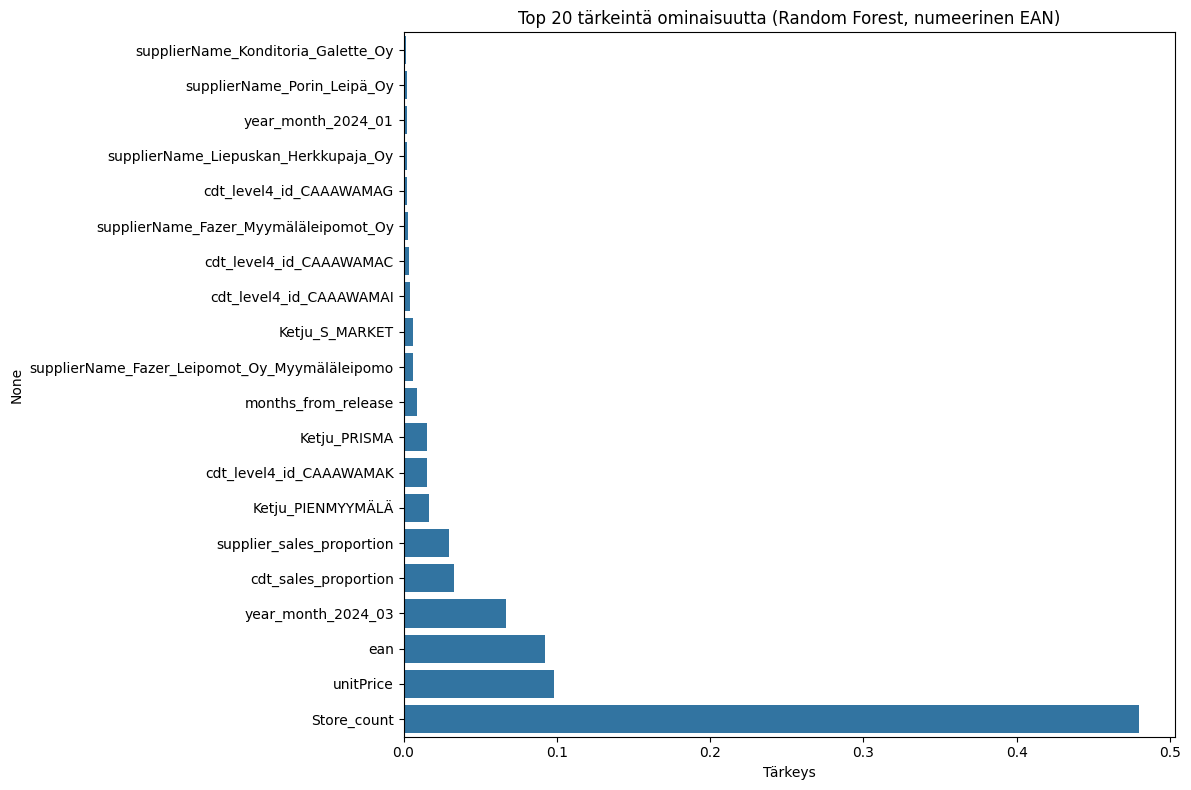


Tärkeimmät ominaisuudet (Random Forest, numeerinen EAN):
months_from_release: 0.0086
Ketju_PRISMA: 0.0152
cdt_level4_id_CAAAWAMAK: 0.0154
Ketju_PIENMYYMÄLÄ: 0.0169
supplier_sales_proportion: 0.0296
cdt_sales_proportion: 0.0327
year_month_2024_03: 0.0666
ean: 0.0921
unitPrice: 0.0981
Store_count: 0.4794


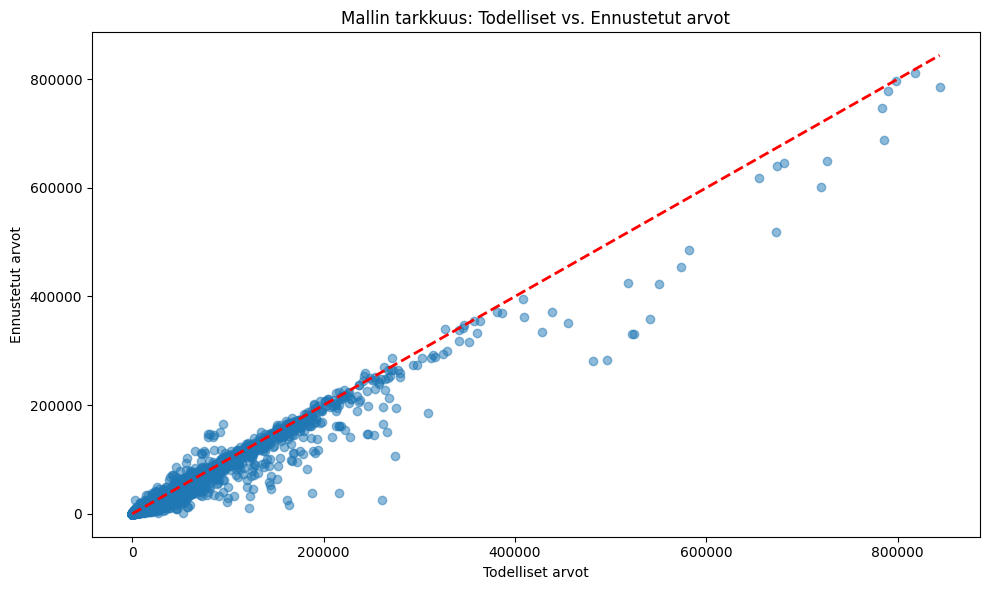

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import drive

# Oletetaan, että vhs_data2 on jo luotu ja sisältää oikeat sarakkeet
df = vhs_data2.copy()

# Käsitellään timestamp-sarake
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year_month'] = df['timestamp'].dt.to_period('M')
df = df.drop(columns=['timestamp'])

# Muunnetaan 'ean' numeeriseksi, jos se ei jo ole
if df['ean'].dtype == 'object':
    df['ean'] = pd.to_numeric(df['ean'], errors='coerce')

# Kategoriset muuttujat binääriseksi, ei sisällä 'ean':ää
categorical_cols = ['Ketju', 'supplierName', 'cdt_level4_id', 'year_month']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))

# Tallennetaan encoder Google Driveen
encoder_path = '/content/drive/MyDrive/ennustus/onehot_encoderSupplier.joblib'
joblib.dump(encoder, encoder_path)
print(f"Encoder tallennettu: {encoder_path}")

# Yhdistetään kategoriset ja numeeriset sarakkeet
numeric_cols = ['ean', 'unitPrice', 'Store count', 'isNew', 'months_from_release', 'SALES_AMOUNT', 'cdt_sales_proportion', 'supplier_sales_proportion']
numeric_df = df[numeric_cols]
final_df = pd.concat([numeric_df, encoded_df], axis=1)

final_df = final_df.dropna()

# Muokataan sarakkeiden nimet
def clean_column_name(name):
    return re.sub(r'[^\w]+', '_', name)

cleaned_columns = [clean_column_name(col) for col in final_df.columns]
unique_columns = []
for col in cleaned_columns:
    if col in unique_columns:
        i = 1
        while f"{col}_{i}" in unique_columns:
            i += 1
        unique_columns.append(f"{col}_{i}")
    else:
        unique_columns.append(col)

final_df.columns = unique_columns

# Määritellään riippumaton (X) ja riippuva (y) muuttuja
X = final_df.drop(columns=['SALES_AMOUNT'])
y = final_df['SALES_AMOUNT']

# Tallennetaan koulutusdatan sarakkeet joblib-tiedostoon
joblib.dump(X.columns, '/content/drive/MyDrive/ennustus/train_columnsSupplier.joblib')

# Käsitellään nolla-arvot ja negatiiviset arvot
y_positive = np.maximum(y, 1e-6)

# Sovelletaan log-muunnosta y-muuttujaan
y_log = np.log(y_positive)

# Tarkistetaan, että y_log ei sisällä NaN- tai äärettömiä arvoja
assert not np.any(np.isnan(y_log)), "y_log sisältää NaN-arvoja"
assert not np.any(np.isinf(y_log)), "y_log sisältää äärettömiä arvoja"

# KFold ristivalidointi
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest -malli
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Apufunktio ennusteiden muuntamiseen takaisin alkuperäiseen asteikkoon
def inverse_transform_predictions(y_pred):
    return np.exp(y_pred)

# Sovitetaan malli
print("Sovitetaan Random Forest...")
rf_model.fit(X, y_log)

# Mallin suorituskyvyn arviointi
y_pred_log = rf_model.predict(X)
y_pred = inverse_transform_predictions(y_pred_log)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"\nRandom Forest - MSE: {mse:.4f}, R2: {r2:.4f}")

# Tallennetaan malli Google Driveen
model_path = '/content/drive/MyDrive/ennustus/random_forest_modelSupplier.joblib'
joblib.dump(rf_model, model_path)
print(f"Malli tallennettu: {model_path}")

# Ominaisuuksien tärkeyden visualisointi
feature_importance = rf_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importance[-20:], y=sorted_features[-20:])
plt.title('Top 20 tärkeintä ominaisuutta (Random Forest, numeerinen EAN)')
plt.xlabel('Tärkeys')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ennustus/feature_importance.png')
plt.show()

print("\nTärkeimmät ominaisuudet (Random Forest, numeerinen EAN):")
for feat, imp in zip(sorted_features[-10:], sorted_importance[-10:]):
    print(f"{feat}: {imp:.4f}")

# Visualisoidaan mallin tarkkuus
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Todelliset arvot')
plt.ylabel('Ennustetut arvot')
plt.title('Mallin tarkkuus: Todelliset vs. Ennustetut arvot')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ennustus/model_accuracy.png')
plt.show()

# Mallin ennustaminen

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import joblib
import re

def inverse_transform_predictions(y_pred_log):
    return np.expm1(y_pred_log)

def predict_sales_amount(new_df):
    original_index = new_df.index
    print(f"Original shape: {new_df.shape}")

    # Load previously saved encoder and model
    encoder = joblib.load('/content/drive/MyDrive/ennustus/onehot_encoderSupplier.joblib')
    rf_model = joblib.load('/content/drive/MyDrive/ennustus/random_forest_modelSupplier.joblib')

    # Process timestamp column in new data
    if 'timestamp' in new_df.columns:
        new_df['timestamp'] = pd.to_datetime(new_df['timestamp'])
        new_df['year_month'] = new_df['timestamp'].dt.to_period('M')
        new_df = new_df.drop(columns=['timestamp'])
    print(f"Shape after timestamp processing: {new_df.shape}")

    # Convert 'ean' to numeric if it's not already
    if new_df['ean'].dtype == 'object':
        new_df['ean'] = pd.to_numeric(new_df['ean'], errors='coerce')
    print(f"Shape after ean conversion: {new_df.shape}")

    # One-hot encode categorical variables
    categorical_cols = ['Ketju', 'supplierName', 'cdt_level4_id', 'year_month']
    encoded_cats = encoder.transform(new_df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols), index=new_df.index)
    print(f"Shape of encoded_df: {encoded_df.shape}")

    # Combine categorical and numeric columns
    numeric_cols = ['ean', 'unitPrice', 'Store count', 'isNew', 'months_from_release', 'cdt_sales_proportion', 'supplier_sales_proportion']
    numeric_df = new_df[numeric_cols]
    print(f"Shape of numeric_df: {numeric_df.shape}")
    final_new_df = numeric_df.join(encoded_df)
    print(f"Shape after joining: {final_new_df.shape}")

    # Clean column names as in the original processing
    def clean_column_name(name):
        return re.sub(r'[^\w]+', '_', name)

    cleaned_columns = [clean_column_name(col) for col in final_new_df.columns]
    unique_columns = []
    for col in cleaned_columns:
        if col in unique_columns:
            i = 1
            while f"{col}_{i}" in unique_columns:
                i += 1
            unique_columns.append(f"{col}_{i}")
        else:
            unique_columns.append(col)

    final_new_df.columns = unique_columns

    # Impute NaN values
    imputer = SimpleImputer(strategy='mean')
    final_new_df_imputed = pd.DataFrame(imputer.fit_transform(final_new_df), columns=final_new_df.columns, index=final_new_df.index)
    print(f"Shape after imputation: {final_new_df_imputed.shape}")

    # Make predictions
    y_pred_log = rf_model.predict(final_new_df_imputed)
    y_pred = inverse_transform_predictions(y_pred_log)
    print(f"Shape of predictions: {y_pred.shape}")

    # Create a DataFrame with predictions and original index
    predictions_df = pd.DataFrame({'predicted_sales': y_pred}, index=original_index)
    print(f"Final predictions shape: {predictions_df.shape}")

    return predictions_df

# Tehdään ennustukset
new_data = new_df.copy()
predictions_df = predict_sales_amount(new_data)

# Tulostetaan alkuperäisen datan ja ennustusten muodot
print(f"Original new_df shape: {new_df.shape}")
print(f"Predictions shape: {predictions_df.shape}")

# Lisätään ennustukset uudeksi sarakkeeksi
new_df = new_df.join(predictions_df)

new_df

Original shape: (10008, 12)
Shape after timestamp processing: (10008, 12)
Shape after ean conversion: (10008, 12)
Shape of encoded_df: (10008, 589)
Shape of numeric_df: (10008, 7)
Shape after joining: (10008, 596)
Shape after imputation: (10008, 596)
Shape of predictions: (10008,)
Final predictions shape: (10008, 1)
Original new_df shape: (10008, 12)
Predictions shape: (10008, 1)


,timestamp,Ketju,ean,supplierName,cdt_level4_id,unitPrice,Store count,isNew,cdt_amount,cdt_sales_proportion,supplier_sales_proportion,months_from_release,predicted_sales
205,2024-04,S-MARKET,200006040004,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWACAA,4.25,1,0,4303894.71,0.05604,0.00000,7,268.090234
214,2024-04,PIENMYYMÄLÄ,200006045030,Suomenniemen Tukiasuntoyhdistys ry,CAAAWAAAK,5.15,1,0,2123630.70,0.02765,0.00000,7,341.907221
225,2024-04,PIENMYYMÄLÄ,200006050515,Oy Emil Halme Ab,CAAAWAMAI,21.25,1,0,6226453.54,0.08107,0.00002,7,1229.836792
236,2024-04,PIENMYYMÄLÄ,200006050560,Oy Emil Halme Ab,CAAAWAMAK,26.88,1,0,5307590.51,0.06910,0.00002,7,253.409211
257,2024-04,S-MARKET,200006115511,PAIKALLINEN TOIMITTAJA (VALMIS RUOKA),CAAAWAMAK,1.00,10,0,5307590.51,0.06910,0.00001,7,984.455899
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146212,2024-04,PRISMA,9998885292034,Jussinhannan Leipä Oy,CAAAWAIAC,73.20,1,0,1138143.58,0.01482,0.00003,7,126.359306
146223,2024-04,PRISMA,9998885426552,Jussinhannan Leipä Oy,CAAAWAIAC,46.40,1,0,1138143.58,0.01482,0.00003,7,148.887452
146234,2024-04,PRISMA,9998885602062,Jussinhannan Leipä Oy,CAAAWAIAC,33.30,1,0,1138143.58,0.01482,0.00003,7,139.378146
146244,2024-04,PRISMA,9998887995179,Jussinhannan Leipä Oy,CAAAWAIAC,59.60,1,0,1138143.58,0.01482,0.00003,7,132.625419


In [ ]:
vhs_data3 # oikea tulos vertialua varten

,timestamp,Ketju,ean,supplierName,cdt_level4_id,unitPrice,Store count,isNew,cdt_amount,cdt_sales_proportion,supplier_sales_proportion,months_from_release,SALES_AMOUNT
25,2024-04,S-MARKET,200006040004,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWACAA,4.25,1,0,4303894.71,0.05604,0.00000,7,257.13
33,2024-04,PIENMYYMÄLÄ,200006050515,Oy Emil Halme Ab,CAAAWAMAI,21.25,1,0,6226453.54,0.08107,0.00002,7,842.68
41,2024-04,PIENMYYMÄLÄ,200006050560,Oy Emil Halme Ab,CAAAWAMAK,26.88,1,0,5307590.51,0.06910,0.00002,7,113.07
55,2024-04,S-MARKET,200006115511,PAIKALLINEN TOIMITTAJA (VALMIS RUOKA),CAAAWAMAK,1.00,10,0,5307590.51,0.06910,0.00001,7,1018.45
63,2024-04,S-MARKET,200006115528,PAIKALLINEN TOIMITTAJA (VALMIS RUOKA),CAAAWAMAK,1.20,10,0,5307590.51,0.06910,0.00001,7,3536.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69375,2024-04,PIENMYYMÄLÄ,8411037892476,Oy Conaxess Trade Finland Ab,CAAAWAGAY,16.45,1,0,178549.71,0.00232,0.00105,7,199.07
69383,2024-04,HERKKU,8411037892476,Oy Conaxess Trade Finland Ab,CAAAWAGAY,16.95,1,0,178549.71,0.00232,0.00105,7,64.41
69391,2024-04,PRISMA,8411037892476,Oy Conaxess Trade Finland Ab,CAAAWAGAY,14.95,73,0,178549.71,0.00232,0.00105,7,2330.74
69399,2024-04,S-MARKET,8411037892476,Oy Conaxess Trade Finland Ab,CAAAWAGAY,15.45,34,0,178549.71,0.00232,0.00105,7,869.58


## Yhdistetään toteutunut ja ennuste

In [ ]:
vhs_data3['timestamp'] = vhs_data3['timestamp'].astype(str)
new_df['timestamp'] = new_df['timestamp'].astype(str)
vhs_data3['ean'] = vhs_data3['ean'].astype(str)
new_df['ean'] = new_df['ean'].astype(str)


vhs_data300 = pd.merge(
    vhs_data3,
    new_df,
    left_on=['timestamp',	'Ketju',	'ean',	'supplierName',	'cdt_level4_id',	'unitPrice',	'Store count',	'isNew',	'cdt_amount',	'cdt_sales_proportion', 'supplier_sales_proportion',	'months_from_release'],
    right_on=['timestamp',	'Ketju',	'ean',	'supplierName',	'cdt_level4_id',	'unitPrice',	'Store count',	'isNew',	'cdt_amount',	'cdt_sales_proportion', 'supplier_sales_proportion',	'months_from_release']
)

vhs_data300

,timestamp,Ketju,ean,supplierName,cdt_level4_id,unitPrice,Store count,isNew,cdt_amount,cdt_sales_proportion,supplier_sales_proportion,months_from_release,SALES_AMOUNT,predicted_sales
0,2024-04,S-MARKET,200006040004,PAIKALLINEN TOIMITTAJA (LEIPÄ),CAAAWACAA,4.25,1,0,4303894.71,0.05604,0.00000,7,257.13,268.090234
1,2024-04,PIENMYYMÄLÄ,200006050515,Oy Emil Halme Ab,CAAAWAMAI,21.25,1,0,6226453.54,0.08107,0.00002,7,842.68,1229.836792
2,2024-04,PIENMYYMÄLÄ,200006050560,Oy Emil Halme Ab,CAAAWAMAK,26.88,1,0,5307590.51,0.06910,0.00002,7,113.07,253.409211
3,2024-04,S-MARKET,200006115511,PAIKALLINEN TOIMITTAJA (VALMIS RUOKA),CAAAWAMAK,1.00,10,0,5307590.51,0.06910,0.00001,7,1018.45,984.455899
4,2024-04,S-MARKET,200006115528,PAIKALLINEN TOIMITTAJA (VALMIS RUOKA),CAAAWAMAK,1.20,10,0,5307590.51,0.06910,0.00001,7,3536.98,2933.808240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7759,2024-04,PIENMYYMÄLÄ,8411037892476,Oy Conaxess Trade Finland Ab,CAAAWAGAY,16.45,1,0,178549.71,0.00232,0.00105,7,199.07,673.628384
7760,2024-04,HERKKU,8411037892476,Oy Conaxess Trade Finland Ab,CAAAWAGAY,16.95,1,0,178549.71,0.00232,0.00105,7,64.41,90.409986
7761,2024-04,PRISMA,8411037892476,Oy Conaxess Trade Finland Ab,CAAAWAGAY,14.95,73,0,178549.71,0.00232,0.00105,7,2330.74,4182.672415
7762,2024-04,S-MARKET,8411037892476,Oy Conaxess Trade Finland Ab,CAAAWAGAY,15.45,34,0,178549.71,0.00232,0.00105,7,869.58,1625.035092


### tallennetaan ennustettu df koneelle

In [ ]:

vhs_data300.to_csv('vhs_data300.csv', index=False)

# Download the file to your local machine
from google.colab import files
files.download('vhs_data300.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

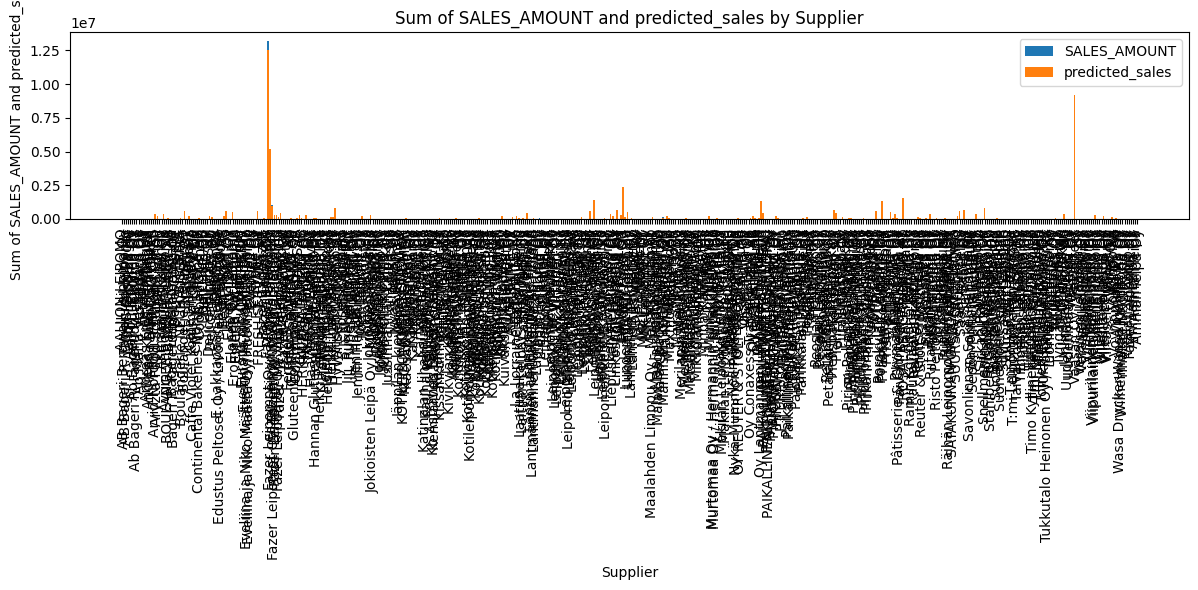

In [ ]:
import matplotlib.pyplot as plt

supplier_sales = vhs_data301.groupby('supplierName')['SALES_AMOUNT'].sum()
supplier_predictions = vhs_data301.groupby('supplierName')['predicted_sales'].sum()
plt.figure(figsize=(12, 6))
plt.bar(supplier_sales.index, supplier_sales.values, label='SALES_AMOUNT')
plt.bar(supplier_predictions.index, supplier_predictions.values, label='predicted_sales')
plt.xlabel('Supplier')
plt.ylabel('Sum of SALES_AMOUNT and predicted_sales')
plt.title('Sum of SALES_AMOUNT and predicted_sales by Supplier')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


# Mallin parametrien optimointi

### Tämä koodi käy läpi paramateri kombinaatiot ja palauttaan parhaan tuloksen saaneet parametrit

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import drive

# Assume vhs_data2 is already created and contains the correct columns
df = vhs_data2.copy()

# Process timestamp column
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year_month'] = df['timestamp'].dt.to_period('M')
df = df.drop(columns=['timestamp'])

# Convert 'ean' to numeric if it's not already
if df['ean'].dtype == 'object':
    df['ean'] = pd.to_numeric(df['ean'], errors='coerce')

# One-hot encode categorical variables, excluding 'ean'
categorical_cols = ['Ketju', 'supplierName', 'cdt_level4_id', 'year_month']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))

# Save encoder to Google Drive
encoder_path = '/content/drive/MyDrive/ennustus/onehot_encoderSupplier.joblib'
joblib.dump(encoder, encoder_path)
print(f"Encoder saved: {encoder_path}")

# Combine categorical and numeric columns
numeric_cols = ['ean', 'unitPrice', 'Store count', 'isNew', 'months_from_release', 'SALES_AMOUNT', 'cdt_sales_proportion', 'supplier_sales_proportion']
numeric_df = df[numeric_cols]
final_df = pd.concat([numeric_df, encoded_df], axis=1)

final_df = final_df.dropna()

# Clean column names
def clean_column_name(name):
    return re.sub(r'[^\w]+', '_', name)

cleaned_columns = [clean_column_name(col) for col in final_df.columns]
unique_columns = []
for col in cleaned_columns:
    if col in unique_columns:
        i = 1
        while f"{col}_{i}" in unique_columns:
            i += 1
        unique_columns.append(f"{col}_{i}")
    else:
        unique_columns.append(col)

final_df.columns = unique_columns

# Define independent (X) and dependent (y) variables
X = final_df.drop(columns=['SALES_AMOUNT'])
y = final_df['SALES_AMOUNT']

# Save training data columns to joblib file
joblib.dump(X.columns, '/content/drive/MyDrive/ennustus/train_columnsSupplier.joblib')

# Handle zero and negative values
y_positive = np.maximum(y, 1e-6)

# Apply log transformation to y variable
y_log = np.log(y_positive)

# Check that y_log doesn't contain NaN or infinite values
assert not np.any(np.isnan(y_log)), "y_log contains NaN values"
assert not np.any(np.isinf(y_log)), "y_log contains infinite values"

# KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest model with GridSearch
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Helper function to transform predictions back to original scale
def inverse_transform_predictions(y_pred):
    return np.exp(y_pred)

# Fit the model with GridSearch
print("Fitting Random Forest with GridSearch...")
grid_search.fit(X, y_log)

# Print best parameters
print("\nBest parameters found:")
print(grid_search.best_params_)

# Use best model for predictions
best_rf_model = grid_search.best_estimator_

# Model performance evaluation
y_pred_log = best_rf_model.predict(X)
y_pred = inverse_transform_predictions(y_pred_log)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"\nBest Random Forest - MSE: {mse:.4f}, R2: {r2:.4f}")

# Save the best model to Google Drive
model_path = '/content/drive/MyDrive/ennustus/best_random_forest_modelSupplier_optimized.joblib'
joblib.dump(best_rf_model, model_path)
print(f"Best model saved: {model_path}")

# Feature importance visualization
feature_importance = best_rf_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importance[-20:], y=sorted_features[-20:])
plt.title('Top 20 Most Important Features (Random Forest, numeric EAN)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ennustus/feature_importance_gridsearch.png')
plt.show()

print("\nMost Important Features (Random Forest, numeric EAN):")
for feat, imp in zip(sorted_features[-10:], sorted_importance[-10:]):
    print(f"{feat}: {imp:.4f}")

# Visualize model accuracy
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model Accuracy: Actual vs. Predicted Values')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ennustus/model_accuracy_gridsearch.png')
plt.show()